# Inventory, ABC Analysis & Economic Impact

## Objective

This notebook closes the analytical loop by linking customer behavior (RFM segments) with inventory structure and revenue concentration. The goal is to identify structural dependencies between:

- Customer segments

- SKU criticality (ABC classes)

- Economic impact on total revenue

This analysis supports decisions in:

- Inventory prioritization

- Risk management

- Supply chain resilience

# 1. Environment Setup

In [16]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 2. Project Paths & Data Loading

In [17]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

DATA_PATH = os.path.join(
    PROJECT_ROOT, "data", "processed", "cleaned_retail_data.csv"
)

from src.feature_engineering import (
    calculate_rfm_metrics,
    perform_abc_analysis
)

# ----------------------
# 3. Data Loading & Inflation Adjustment
# ----------------------

df = pd.read_csv(DATA_PATH, parse_dates=["InvoiceDate"])

df["TotalSum"] = df["Quantity"] * df["Price"]

df["Year"] = df["InvoiceDate"].dt.year

INFLATION_2011 = 0.039
df.loc[df["Year"] == 2011, ["TotalSum", "Price"]] /= (1 + INFLATION_2011)

df_2010 = df[df["Year"] == 2010].copy()
df_2011 = df[df["Year"] == 2011].copy()

# 3. Load RFM Segments

RFM segmentation results from the previous notebook are reconstructed to ensure reproducibility.

In [19]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby("Customer ID")
      .agg({
          "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
          "Invoice": "nunique",
          "TotalSum": "sum"
      })
      .rename(columns={
          "InvoiceDate": "Recency",
          "Invoice": "Frequency",
          "TotalSum": "Monetary"
      })
)

rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)


def assign_segment(row):
    r, f, m = row["R_Score"], row["F_Score"], row["M_Score"]
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions (VIP)"
    elif m >= 4 and r >= 3:
        return "Big Spenders"
    elif r <= 2:
        return "At Risk / Hibernating"
    else:
        return "Core Customers"

rfm["Segment"] = rfm.apply(assign_segment, axis=1)

# 4. ABC Inventory Classification

ABC analysis ranks SKUs by revenue contribution to identify critical inventory items.

In [20]:
sku_revenue = (
    df.groupby("Description", as_index=False)["TotalSum"]
      .sum()
      .sort_values("TotalSum", ascending=False)
)

sku_revenue["Revenue_Share"] = sku_revenue["TotalSum"].cumsum()
sku_revenue["Revenue_Share_Pct"] = (
    100 * sku_revenue["Revenue_Share"] / sku_revenue["TotalSum"].sum()
)

sku_revenue["ABC_Class"] = pd.cut(
    sku_revenue["Revenue_Share_Pct"],
    bins=[0, 80, 95, 100],
    labels=["A", "B", "C"]
)

sku_revenue.head()

,Description,TotalSum,Revenue_Share,Revenue_Share_Pct,ABC_Class
3753,REGENCY CAKESTAND 3 TIER,250956.104100,250956.104100,1.591589,A
5065,WHITE HANGING HEART T-LIGHT HOLDER,187323.986208,438280.090308,2.779617,A
3146,PARTY BUNTING,130086.218980,568366.309288,3.604637,A
2389,JUMBO BAG RED RETROSPOT,102480.113609,670846.422897,4.254576,A
3114,PAPER CHAIN KIT 50'S CHRISTMAS,81170.082368,752016.505265,4.769365,A


# 5. Pareto Curve Visualization

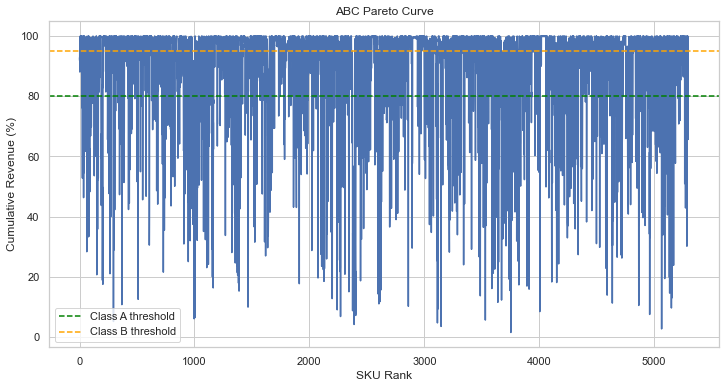

In [21]:
sns.lineplot(data=sku_revenue, x=sku_revenue.index, y="Revenue_Share_Pct")
plt.axhline(80, linestyle="--", color="green", label="Class A threshold")
plt.axhline(95, linestyle="--", color="orange", label="Class B threshold")
plt.ylabel("Cumulative Revenue (%)")
plt.xlabel("SKU Rank")
plt.title("ABC Pareto Curve")
plt.legend()
plt.show()

### Interpretation:

- Class A SKUs dominate revenue

- Small disruptions can have outsized impact

# 6. Linking Customers to Inventory

In [7]:
sku_class_map = sku_revenue.set_index("Description")["ABC_Class"]

df = df.assign(
    ABC_Class=df["Description"].map(sku_class_map)
)

df_enriched = df.merge(
    rfm[["Segment"]],
    left_on="Customer ID",
    right_index=True,
    how="left"
)

# 7. Inventory Dependency by Segment

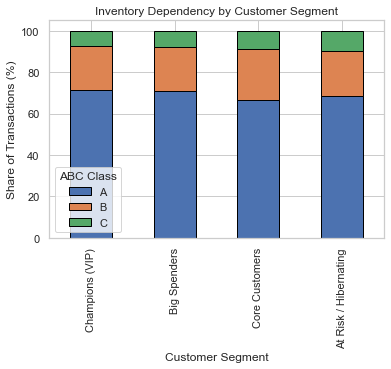

In [8]:
segment_inventory = (
    pd.crosstab(
        df_enriched["Segment"],
        df_enriched["ABC_Class"],
        normalize="index"
    ) * 100
)

segment_inventory

segment_inventory.loc[[
    "Champions (VIP)",
    "Big Spenders",
    "Core Customers",
    "At Risk / Hibernating"
]].plot(
    kind="bar",
    stacked=True,
    edgecolor="black"
)

plt.title("Inventory Dependency by Customer Segment")
plt.ylabel("Share of Transactions (%)")
plt.xlabel("Customer Segment")
plt.legend(title="ABC Class")
plt.show()

# 8. Economic Impact by Segment

In [11]:
segment_wealth = (
    rfm.groupby("Segment", as_index=False)["Monetary"]
       .sum()
       .assign(
           Revenue_%=lambda x: 100 * x["Monetary"] / x["Monetary"].sum()
       )
       .sort_values("Revenue_%", ascending=False)
)

segment_wealth

SyntaxError: invalid syntax (4139780944.py, line 5)

# 9. Key Business Insights

- Revenue is highly concentrated in a small subset of SKUs (Class A)

- Champions and Big Spenders depend disproportionately on Class A inventory

- Inventory disruptions in Class A SKUs directly threaten top-line revenue

- Core and At-Risk customers rely more on B/C inventory

# 10. Strategic Implications

- Prioritize Class A SKU availability for VIP segments

- Align safety stock policies with customer value

- Use segment-level ABC dependency for risk stress-testing

# 11. Final Note

This notebook completes a behavior → inventory → revenue analytical chain, enabling data-driven supply chain decisions grounded in customer economics.



✅ RFM metrics calculated for 4164 unique customers.
✅ RFM metrics calculated for 4175 unique customers.
✅ ABC Analysis complete.
✅ ABC Analysis complete.


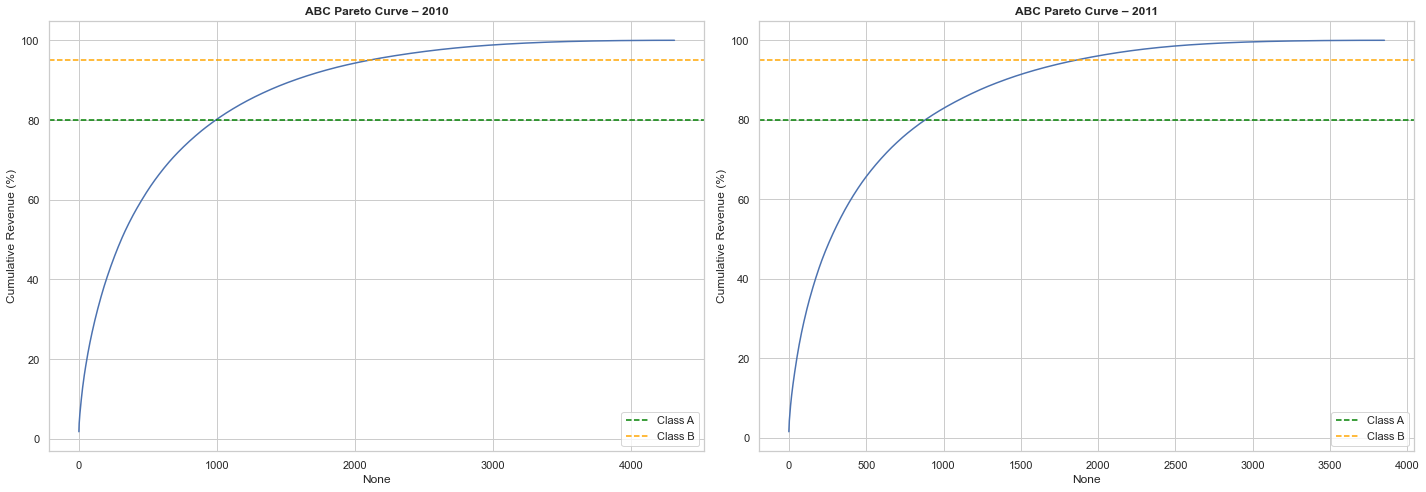

,Segment,Monetary,Revenue_%
2,Champions (VIP),"£4,269,543.27",62.2%
0,At Risk / Hibernating,"£1,113,011.09",16.2%
1,Big Spenders,"£945,809.51",13.8%
3,Core Customers,"£537,012.23",7.8%


,Segment,Monetary,Revenue_%
2,Champions (VIP),"£3,865,851.37",62.7%
0,At Risk / Hibernating,"£962,258.07",15.6%
1,Big Spenders,"£872,869.55",14.2%
3,Core Customers,"£466,259.14",7.6%


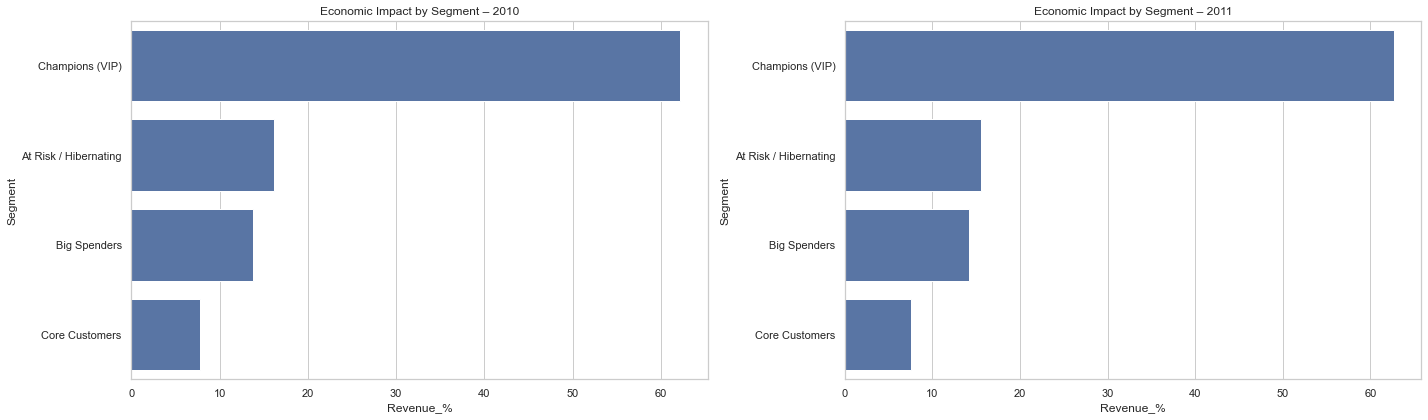

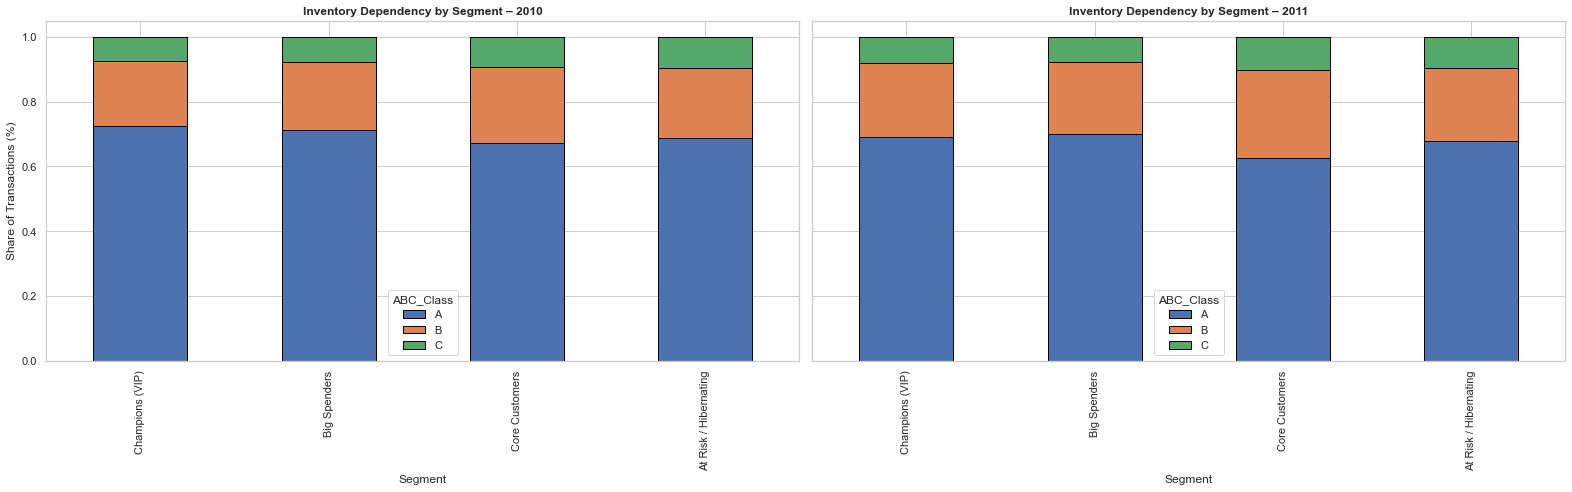

✅ Inventory, ABC analysis and economic impact assessment complete.


In [15]:
# ===============================================================
# 04_inventory_abc_impact.ipynb
# Inventory, ABC Analysis & Economic Impact
# ===============================================================

# ----------------------
# 1. Environment Setup
# ----------------------

import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# ----------------------
# 2. Project Paths & Imports
# ----------------------

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

DATA_PATH = os.path.join(
    PROJECT_ROOT, "data", "processed", "cleaned_retail_data.csv"
)

from src.feature_engineering import (
    calculate_rfm_metrics,
    perform_abc_analysis
)

# ----------------------
# 3. Data Loading & Inflation Adjustment
# ----------------------

df = pd.read_csv(DATA_PATH, parse_dates=["InvoiceDate"])

if "TotalSum" not in df.columns:
    df["TotalSum"] = df["Quantity"] * df["Price"]

df["Year"] = df["InvoiceDate"].dt.year

INFLATION_2011 = 0.039
df.loc[df["Year"] == 2011, ["TotalSum", "Price"]] /= (1 + INFLATION_2011)

df_2010 = df[df["Year"] == 2010].copy()
df_2011 = df[df["Year"] == 2011].copy()

# ----------------------
# 4. Rebuild RFM Segments (Reproducibility)
# ----------------------

def build_rfm_segments(df_year):
    rfm = calculate_rfm_metrics(df_year)

    rfm["R_Score"] = pd.qcut(
        rfm["Recency"], 5, labels=[5, 4, 3, 2, 1]
    ).astype(int)

    rfm["F_Score"] = pd.qcut(
        rfm["Frequency"].rank(method="first"),
        5, labels=[1, 2, 3, 4, 5]
    ).astype(int)

    rfm["M_Score"] = pd.qcut(
        rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5]
    ).astype(int)

    def assign_segment(row):
        r, f, m = row["R_Score"], row["F_Score"], row["M_Score"]
        if r >= 4 and f >= 4 and m >= 4:
            return "Champions (VIP)"
        elif m >= 4 and r >= 3:
            return "Big Spenders"
        elif r <= 2:
            return "At Risk / Hibernating"
        else:
            return "Core Customers"

    rfm["Segment"] = rfm.apply(assign_segment, axis=1)
    return rfm

rfm_2010 = build_rfm_segments(df_2010)
rfm_2011 = build_rfm_segments(df_2011)

# ----------------------
# 5. Inventory & Economic Impact Processing
# ----------------------

def process_inventory_impact(df_year, rfm_year):
    abc = perform_abc_analysis(df_year)

    sku_map = abc.set_index("Description")["ABC_Class"]
    df_year = df_year.assign(
        ABC_Class=df_year["Description"].map(sku_map)
    )

    segment_wealth = (
        rfm_year.groupby("Segment", as_index=False)["Monetary"]
        .sum()
    )

    segment_wealth["Revenue_%"] = (
        100 * segment_wealth["Monetary"] / segment_wealth["Monetary"].sum()
    )

    segment_wealth = segment_wealth.sort_values(
        "Revenue_%", ascending=False
    )

    return abc, segment_wealth, df_year

abc_2010, wealth_2010, df_2010 = process_inventory_impact(df_2010, rfm_2010)
abc_2011, wealth_2011, df_2011 = process_inventory_impact(df_2011, rfm_2011)

# ----------------------
# 6. ABC Pareto Curves (Side-by-Side)
# ----------------------

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for i, (abc, yr) in enumerate([(abc_2010, 2010), (abc_2011, 2011)]):
    sns.lineplot(
        data=abc,
        x=abc.index,
        y="Revenue_Share_Pct",
        ax=axes[i]
    )
    axes[i].axhline(80, linestyle="--", color="green", label="Class A")
    axes[i].axhline(95, linestyle="--", color="orange", label="Class B")
    axes[i].set_title(f"ABC Pareto Curve – {yr}", fontweight="bold")
    axes[i].set_ylabel("Cumulative Revenue (%)")
    axes[i].legend()

plt.tight_layout()
plt.show()

# ----------------------
# 7. Economic Impact Tables
# ----------------------

display(
    wealth_2010.style.format(
        {"Monetary": "£{:,.2f}", "Revenue_%": "{:.1f}%"}
    )
)

display(
    wealth_2011.style.format(
        {"Monetary": "£{:,.2f}", "Revenue_%": "{:.1f}%"}
    )
)

# ----------------------
# 8. Economic Impact Visualization
# ----------------------

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.barplot(
    data=wealth_2010,
    x="Revenue_%",
    y="Segment",
    ax=axes[0]
)
axes[0].set_title("Economic Impact by Segment – 2010")

sns.barplot(
    data=wealth_2011,
    x="Revenue_%",
    y="Segment",
    ax=axes[1]
)
axes[1].set_title("Economic Impact by Segment – 2011")

plt.tight_layout()
plt.show()

# ----------------------
# 9. Inventory Dependency Root Cause
# ----------------------

order = [
    "Champions (VIP)",
    "Big Spenders",
    "Core Customers",
    "At Risk / Hibernating"
]

fig, axes = plt.subplots(1, 2, figsize=(22, 7), sharey=True)

for i, (df_en, yr) in enumerate([
    (df_2010.merge(rfm_2010["Segment"], left_on="Customer ID", right_index=True), 2010),
    (df_2011.merge(rfm_2011["Segment"], left_on="Customer ID", right_index=True), 2011)
]):
    pd.crosstab(
        df_en["Segment"],
        df_en["ABC_Class"],
        normalize="index"
    ).reindex(order).plot(
        kind="bar",
        stacked=True,
        ax=axes[i],
        edgecolor="black"
    )
    axes[i].set_title(f"Inventory Dependency by Segment – {yr}", fontweight="bold")
    axes[i].set_ylabel("Share of Transactions (%)")

plt.tight_layout()
plt.show()

print("✅ Inventory, ABC analysis and economic impact assessment complete.")
